> **IMPORTANT**: Before running this notebook, ensure you have ran:
> ```bash
> python ./scripts/preprocessing/preprocess_data.py
> ``` 
> You will know if you ran this if you see a `pickled_objects` folder in your root directory. This folder will be used to load in preprocessed data and the saved preprcoessor.

# Import Libraries

In [1]:
from utils.preprocessing import load_preprocessed_data, load_preprocessor
from models.mlp import MLP, Trainer, ASLDataset, plot_history
from models.sklearn import SklearnClassifier, load_model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from typing import Literal
from collections import defaultdict
import pickle
from xgboost import XGBClassifier

I0000 00:00:1733186054.397564  278573 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733186054.405058  278752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733186054.409366  278745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [2]:
# Define dictionary for scores
models = defaultdict(dict[Literal['val_accuracy', 'test_accuracy'], float]) 

# Get Data and Preprocesssor

In [3]:
train_data = load_preprocessed_data('train')
val_data = load_preprocessed_data('val')
test_data = load_preprocessed_data('test')
preprocessor = load_preprocessor()

In [4]:
train_data[0].shape

(56066, 4096)

# Train Models

## KNN

### Train and Evaluate Model

In [5]:
knn = SklearnClassifier(
    classifier=KNeighborsClassifier(n_neighbors=4),
    train_data=train_data,
    val_data=val_data,
    test_data=test_data
)

# Fit model
knn.fit(model_name='knn')

# Get cross val score
val_score_knn = knn.val_acc_score()
models['KNN']['val_accuracy'] = val_score_knn
print(f'KNN Validation Score: {val_score_knn:.4f}')

# Get test score
test_score_knn = knn.test_acc_score()
models['KNN']['test_accuracy'] = test_score_knn
print(f'KNN Test Score: {test_score_knn:.4f}')

Saved knn to pickled_objects/knn.pkl
KNN Validation Score: 0.6777
KNN Test Score: 0.7572


### Load in Pickled Model

In [6]:
knn = load_model('knn')
knn

KNeighborsClassifier(n_neighbors=4)

### Get Classification Report

In [7]:
y_true = test_data[-1]
y_pred = knn.predict(test_data[0])
y_true_labels = preprocessor.label_encoder.inverse_transform(y=y_true)
y_pred_labels = preprocessor.label_encoder.inverse_transform(y=y_pred)
report = classification_report(y_true=y_true_labels, y_pred=y_pred_labels)
print(report)

              precision    recall  f1-score   support

           A       0.96      0.83      0.89       204
           B       0.97      0.86      0.91       260
       Blank       0.20      1.00      0.33       400
           C       0.91      0.76      0.83       190
           D       0.99      0.75      0.85       313
           E       0.98      0.77      0.86       217
           F       0.98      0.66      0.79       360
           G       0.99      0.64      0.78       272
           H       1.00      0.71      0.83       298
           I       1.00      0.84      0.91       296
           J       0.98      0.72      0.83       269
           K       0.99      0.80      0.89       352
           L       0.99      0.71      0.83       293
           M       0.79      0.38      0.52       110
           N       0.93      0.46      0.61       123
           O       0.93      0.69      0.79       181
           P       1.00      0.67      0.81       224
           Q       0.96    

## Random Forest

### Fit and Evaluation Model

In [8]:
rf = SklearnClassifier(
    classifier=RandomForestClassifier(n_estimators=50),
    train_data=train_data,
    val_data=val_data,
    test_data=test_data
)

# Fit model
rf.fit(model_name='random_forest')

# Get cross val score
val_score_rf = rf.val_acc_score()
models['Random Forest']['val_accuracy'] = val_score_rf
print(f'Random Forest Validation Score: {val_score_rf:.4f}')

# Get test score
test_score_rf = rf.test_acc_score()
models['Random Forest']['test_accuracy'] = test_score_rf
print(f'Random Forest Test Score: {test_score_rf:.4f}')

Saved random_forest to pickled_objects/random_forest.pkl
Random Forest Validation Score: 0.8689
Random Forest Test Score: 0.8955


### Load in Pickled Model

In [9]:
rf = load_model('random_forest')
rf

RandomForestClassifier(n_estimators=50)

### Get Classification Report

In [10]:
y_true = test_data[-1]
y_pred = rf.predict(test_data[0])
y_true_labels = preprocessor.label_encoder.inverse_transform(y=y_true)
y_pred_labels = preprocessor.label_encoder.inverse_transform(y=y_pred)
report = classification_report(y_true=y_true_labels, y_pred=y_pred_labels)
print(report)

              precision    recall  f1-score   support

           A       0.92      0.89      0.91       204
           B       0.90      0.92      0.91       260
       Blank       0.99      1.00      0.99       400
           C       0.89      0.89      0.89       190
           D       0.84      0.90      0.87       313
           E       0.89      0.90      0.90       217
           F       0.72      0.97      0.83       360
           G       0.87      0.88      0.87       272
           H       0.95      0.95      0.95       298
           I       0.93      0.93      0.93       296
           J       0.84      0.87      0.85       269
           K       0.96      0.94      0.95       352
           L       0.80      0.98      0.88       293
           M       0.91      0.28      0.43       110
           N       0.89      0.63      0.74       123
           O       0.82      0.91      0.87       181
           P       0.89      0.77      0.82       224
           Q       0.88    

## XGBoost

## Fit and Evaluate Model

In [11]:
xgb = SklearnClassifier(
    classifier=XGBClassifier(),
    train_data=train_data,
    test_data=test_data,
    val_data=val_data
)

# Fit model
xgb.fit(model_name='xgboost')

# Get cross val score
val_score_xgb = xgb.val_acc_score()
models['XGBoost']['val_accuracy'] = val_score_xgb
print(f'XGBoost Validation Score: {val_score_xgb:.4f}')

# Get test score
test_score_xgb = xgb.test_acc_score()
models['XGBoost']['test_accuracy'] = test_score_xgb
print(f'XGBoost Test Score: {test_score_xgb:.4f}')

Saved xgboost to pickled_objects/xgboost.pkl
XGBoost Validation Score: 0.9191
XGBoost Test Score: 0.9267


### Load in Pickled Model

In [12]:
xgb = load_model('xgboost')
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Get Classification Report

In [13]:
y_true = test_data[-1]
y_pred = xgb.predict(test_data[0])
y_true_labels = preprocessor.label_encoder.inverse_transform(y=y_true)
y_pred_labels = preprocessor.label_encoder.inverse_transform(y=y_pred)
report = classification_report(y_true=y_true_labels, y_pred=y_pred_labels)
print(report)

              precision    recall  f1-score   support

           A       0.94      0.94      0.94       204
           B       0.96      0.93      0.94       260
       Blank       0.96      1.00      0.98       400
           C       0.96      0.90      0.93       190
           D       0.89      0.94      0.91       313
           E       0.89      0.91      0.90       217
           F       0.91      0.96      0.93       360
           G       0.92      0.92      0.92       272
           H       0.98      0.96      0.97       298
           I       0.95      0.95      0.95       296
           J       0.87      0.91      0.89       269
           K       0.95      0.96      0.96       352
           L       0.91      0.97      0.94       293
           M       0.79      0.58      0.67       110
           N       0.86      0.78      0.82       123
           O       0.93      0.91      0.92       181
           P       0.90      0.88      0.89       224
           Q       0.88    

## MLP

### Initialize Network

In [14]:
input_dim = train_data[0].shape[-1]
output_dim = len(np.unique(train_data[-1]))
model = MLP(input_dim=input_dim, output_dim=output_dim)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=128, out_features=29, bias=True)
  )
)


### Initialize Trainer

In [15]:
trainer = Trainer(
    model=model,
    optimizer=optim.Adam,
    learning_rate=5e-4,
    loss_fn=nn.CrossEntropyLoss(),
    dataset_cls=ASLDataset,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    batch_size=64,
    num_epochs=100,
    optimizer_kwargs={'weight_decay': 1e-4}, # Add l2 regularization
    patience=5
)

### Train Model

In [16]:
history = trainer.train()

Epoch 1/100:


Val Loss: 0.3312, Val Acc: 0.9100: 100%|██████████| 138/138 [00:00<00:00, 316.20it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 2/100:


Val Loss: 0.2465, Val Acc: 0.9300: 100%|██████████| 138/138 [00:00<00:00, 310.64it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 3/100:


Val Loss: 0.2250, Val Acc: 0.9365: 100%|██████████| 138/138 [00:00<00:00, 294.09it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 4/100:


Val Loss: 0.2067, Val Acc: 0.9445: 100%|██████████| 138/138 [00:00<00:00, 316.68it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 5/100:


Val Loss: 0.2069, Val Acc: 0.9433: 100%|██████████| 138/138 [00:00<00:00, 314.95it/s]



Epoch 6/100:


Val Loss: 0.2110, Val Acc: 0.9470: 100%|██████████| 138/138 [00:00<00:00, 327.53it/s]



Epoch 7/100:


Val Loss: 0.1914, Val Acc: 0.9489: 100%|██████████| 138/138 [00:00<00:00, 319.38it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 8/100:


Val Loss: 0.2022, Val Acc: 0.9505: 100%|██████████| 138/138 [00:00<00:00, 315.40it/s]



Epoch 9/100:


Val Loss: 0.1780, Val Acc: 0.9556: 100%|██████████| 138/138 [00:00<00:00, 319.21it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 10/100:


Val Loss: 0.1876, Val Acc: 0.9564: 100%|██████████| 138/138 [00:00<00:00, 298.35it/s]



Epoch 11/100:


Val Loss: 0.1823, Val Acc: 0.9591: 100%|██████████| 138/138 [00:00<00:00, 320.82it/s]



Epoch 12/100:


Val Loss: 0.2045, Val Acc: 0.9520: 100%|██████████| 138/138 [00:00<00:00, 332.42it/s]



Epoch 13/100:


Val Loss: 0.1744, Val Acc: 0.9577: 100%|██████████| 138/138 [00:00<00:00, 323.37it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 14/100:


Val Loss: 0.1945, Val Acc: 0.9533: 100%|██████████| 138/138 [00:00<00:00, 319.16it/s]



Epoch 15/100:


Val Loss: 0.1851, Val Acc: 0.9580: 100%|██████████| 138/138 [00:00<00:00, 296.10it/s]



Epoch 16/100:


Val Loss: 0.1911, Val Acc: 0.9569: 100%|██████████| 138/138 [00:00<00:00, 306.98it/s]



Epoch 17/100:


Val Loss: 0.2051, Val Acc: 0.9521: 100%|██████████| 138/138 [00:00<00:00, 305.35it/s]



Epoch 18/100:


Val Loss: 0.1842, Val Acc: 0.9609: 100%|██████████| 138/138 [00:00<00:00, 322.41it/s]


Early stopping triggered at epoch 18.
Restoring weights back to epoch 13.


### Visualize Training

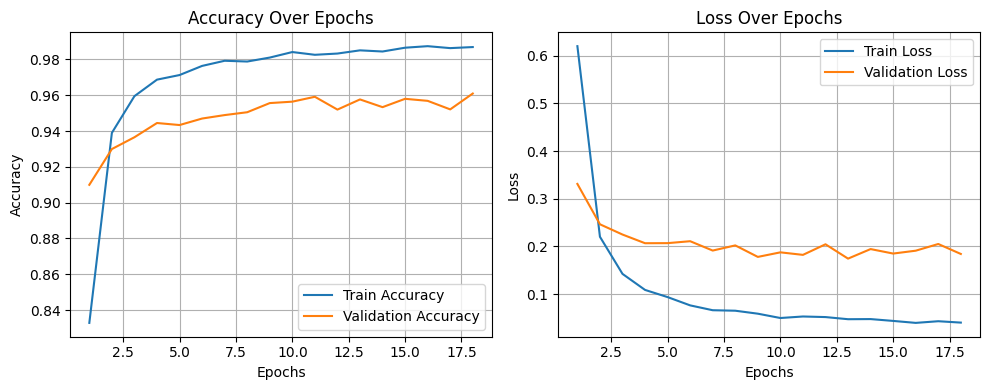

In [17]:
plot_history(history=history)

### Load in Cached Weights (only if they are not in memory)

In [18]:
trainer.load_checkpointed_weights('weights/best_model_checkpoint.pth')
trainer.batch_loaders()

Successfully loaded in weights from weights/best_model_checkpoint.pth.


### Pickle Trainer

In [19]:
with open('pickled_objects/trainer.pkl', 'wb') as f:
    pickle.dump(trainer, f)

### Evalaute Model on Val and Test Set 

In [20]:
val_stats = trainer.evaluate(loader_type='val')
models['MLP']['val_accuracy'] = val_stats['accuracy']

Val Loss: 0.1744, Val Acc: 0.9577: 100%|██████████| 138/138 [00:00<00:00, 263.36it/s]


In [21]:
test_stats = trainer.evaluate(loader_type='test')
models['MLP']['test_accuracy'] = test_stats['accuracy']

Test Loss: 0.1646, Test Acc: 0.9633: 100%|██████████| 113/113 [00:00<00:00, 289.57it/s]


### Get Full Classification Report

In [22]:
preds = preprocessor.label_encoder.inverse_transform(torch.cat([trainer.predict(x.reshape(1, -1)) for x in test_data[0]]).numpy())
truths = preprocessor.label_encoder.inverse_transform(test_data[-1])

In [23]:
report = classification_report(y_true=truths, y_pred=preds)
print(report)

              precision    recall  f1-score   support

           A       0.95      0.95      0.95       204
           B       1.00      0.98      0.99       260
       Blank       1.00      1.00      1.00       400
           C       0.98      0.93      0.95       190
           D       0.97      0.99      0.98       313
           E       0.96      0.95      0.95       217
           F       0.97      0.97      0.97       360
           G       0.96      0.98      0.97       272
           H       0.98      0.98      0.98       298
           I       0.97      0.98      0.97       296
           J       0.91      0.94      0.93       269
           K       0.99      0.97      0.98       352
           L       0.98      0.99      0.99       293
           M       0.74      0.83      0.78       110
           N       0.91      0.82      0.86       123
           O       0.97      0.97      0.97       181
           P       0.96      0.93      0.95       224
           Q       0.94    

# Compare Models

In [24]:
# Convert models DataFrame to a styled DataFrame and remove trailing zeros
models_df = pd.DataFrame(models)  # Convert to DataFrame
models_df = models_df.map(lambda x: ('%.4f' % x)).T  # Remove trailing zeros
models_df.sort_values('test_accuracy', ascending=False, inplace=True)  # Sort by test accuracy

# Highlight best model
top_model = models_df.index[0]
df_styled = models_df.style.apply(
    lambda row: ['background-color: green' if row.name == top_model else '' for _ in row], axis=1
)
df_styled

,val_accuracy,test_accuracy
MLP,0.9577,0.9633
XGBoost,0.9191,0.9267
Random Forest,0.8689,0.8955
KNN,0.6777,0.7572
